# Generating 3 dataset for the 3 different NN

## Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep

import os
import warnings

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, callbacks, regularizers

## Setup 

In [83]:
hep.style.use("CMS")

warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 70

print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)


Training device: GPU


In [10]:
USER = os.getenv("USER")

# FILE_PATH = "/eos/cms/store/cmst3/group/daql1scout/ml_data/run3/bmtf_stubs_refit/"  # Duplicated features Datasets, I don't have access
# FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit/" # Duplicated features Datasets
FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit_dummy/" # Masked features Datasets
FILE_NAME = "rereco"


FILE_SAVE_DATA = "/mnt/ml_data/run3/bmtf_stubs_refit_dummy/Data3NN/"

OUT_PATH = "."

FIGSIZE = (12, 9)

petroff_10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', petroff_10)

## Read data

In [11]:
stub_features = [
    'n_stubs', 
    's1_stNum', 's1_scNum', 's1_whNum', 's1_eta_1', 's1_qeta_1', 's1_eta_2', 's1_qeta_2', 's1_tag', 's1_phi', 's1_phiB', 's1_quality', 
    's2_stNum', 's2_scNum', 's2_whNum', 's2_eta_1', 's2_qeta_1', 's2_eta_2', 's2_qeta_2', 's2_tag', 's2_phi', 's2_phiB', 's2_quality', 
    's3_stNum', 's3_scNum', 's3_whNum', 's3_eta_1', 's3_qeta_1', 's3_eta_2', 's3_qeta_2', 's3_tag', 's3_phi', 's3_phiB', 's3_quality', 
    's4_stNum', 's4_scNum', 's4_whNum', 's4_eta_1', 's4_qeta_1', 's4_eta_2', 's4_qeta_2', 's4_tag', 's4_phi', 's4_phiB', 's4_quality'
]

target_features = [
    'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2', 'chargeReco',
]

l1_features = [
    'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
]

In [12]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        print(f"Loaded {file}")
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 256]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 256]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

Loaded ZeroBias-Run2023C-ReReco.csv
Loaded MuonEG-Run2023C-ReReco.csv


In [13]:
full_data

n_stubs  s1_stNum  s1_scNum  s1_whNum  s1_eta_1  s1_qeta_1  s1_eta_2  \
1              3         1        10        -1       -46          2       255   
3              3         1         8         1         7          0         7   
4              2     -9999     -9999     -9999     -9999      -9999     -9999   
5              4         1         8         1         7          0         7   
6              2         1        10        -1       -52          2       255   
...          ...       ...       ...       ...       ...        ...       ...   
3432730        3     -9999     -9999     -9999     -9999      -9999     -9999   
3432731        2         1         9         0         7          0         7   
3432732        2         1         0         1         7          0         7   
3432733        3     -9999     -9999     -9999     -9999      -9999     -9999   
3432734        3     -9999     -9999     -9999     -9999      -9999     -9999   

         s1_qeta_2  s1_tag  s1_phi  s1_phiB  s1_quality  s2_stNum  s2_scNum  \
1                0       1     344     -119           6         2        10   
3                0       1    -414     -149           2         2         8   
4            -9999   -9999   -9999    -9999       -9999         2         0   
5                0       1    -153      130           5         2         8   
6                0       1    -332      138           5         2        10   
...            ...     ...     ...      ...         ...       ...       ...   
3432730      -9999   -9999   -9999    -9999       -9999         2         7   
3432731          0       1    1069       21           2         2        10   
3432732          0       1     698       83           6     -9999     -9999   
3432733      -9999   -9999   -9999    -9999       -9999         2         5   
3432734      -9999   -9999   -9999    -9999       -9999         2         0   

         s2_whNum  s2_eta_1  s2_qeta_1  s2_eta_2  s2_qeta_2  s2_tag  s2_phi  \
1              -1       -50          2       -45          1       1     212   
3               2        73          2       255          0       1    -625   
4               0        12          2       255          0       1    -788   
5               1        55          2       255          0       1      11   
6              -1       -50          2       255          0       1    -172   
...           ...       ...        ...       ...        ...     ...     ...   
3432730         1         7          0         7          0       1     106   
3432731         0       -17          2       255          0       1   -1022   
3432732     -9999     -9999      -9999     -9999      -9999   -9999   -9999   
3432733        -2         7          0         7          0       1    -851   
3432734         1        29          2       255          0       1    -452   

         s2_phiB  s2_quality  s3_stNum  s3_scNum  s3_whNum  s3_eta_1  \
1            -70           6         3        10        -1       -46   
3           -104           6         3         8         2        74   
4            -82           6     -9999     -9999     -9999     -9999   
5             95           6         3         8         1         7   
6             89           5     -9999     -9999     -9999     -9999   
...          ...         ...       ...       ...       ...       ...   
3432730       91           3         3         7         1        29   
3432731       64           5     -9999     -9999     -9999     -9999   
3432732    -9999       -9999         3         0         1        38   
3432733        3           3         3         5        -2         7   
3432734      -16           5         3         0         1         7   

         s3_qeta_1  s3_eta_2  s3_qeta_2  s3_tag  s3_phi  s3_phiB  s3_quality  \
1                2       255          0       1     136      -17           3   
3                1       255          0       1    -729      -29           5   
4            -9999     -9999     

## Data partitioning

In [91]:
full_data['n_stubs'].value_counts()

n_stubs
2    1252966
3     992449
4     686170
Name: count, dtype: int64

In [92]:
#divide the full_data in 3 diffenet dataset with 2,3 and 4 stubs respectively using the n_stubs feature
full_data_2 = full_data[full_data['n_stubs'] == 2]
full_data_3 = full_data[full_data['n_stubs'] == 3]
full_data_4 = full_data[full_data['n_stubs'] == 4]

# Remember to change the size of the dataset

In [93]:
# full_data_2 = full_data_2[:10000]
# full_data_3 = full_data_3[:10000]
# full_data_4 = full_data_4[:10000]

In [94]:
full_data_2.keys()

Index(['n_stubs', 's1_stNum', 's1_scNum', 's1_whNum', 's1_eta_1', 's1_qeta_1',
       's1_eta_2', 's1_qeta_2', 's1_tag', 's1_phi', 's1_phiB', 's1_quality',
       's2_stNum', 's2_scNum', 's2_whNum', 's2_eta_1', 's2_qeta_1', 's2_eta_2',
       's2_qeta_2', 's2_tag', 's2_phi', 's2_phiB', 's2_quality', 's3_stNum',
       's3_scNum', 's3_whNum', 's3_eta_1', 's3_qeta_1', 's3_eta_2',
       's3_qeta_2', 's3_tag', 's3_phi', 's3_phiB', 's3_quality', 's4_stNum',
       's4_scNum', 's4_whNum', 's4_eta_1', 's4_qeta_1', 's4_eta_2',
       's4_qeta_2', 's4_tag', 's4_phi', 's4_phiB', 's4_quality',
       'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2', 'chargeReco', 'ptL1',
       'etaL1', 'phiL1', 'hwSignL1'],
      dtype='object')

# Dataset 1: 2s data with 2 groups of stubs

In [95]:
always_present_features = [col for col in full_data.columns if not any(prefix in col for prefix in ['s1', 's2', 's3', 's4'])]
always_present_features

['n_stubs',
 'ptRecoInverse',
 'etaExtRecoSt2',
 'phiExtRecoSt2',
 'chargeReco',
 'ptL1',
 'etaL1',
 'phiL1',
 'hwSignL1']

In [96]:
#common features
always_present_features = [col for col in full_data.columns if not any(prefix in col for prefix in ['s1', 's2', 's3', 's4'])]

In [97]:
# Identify feature groups
s1_features = [col for col in full_data.columns if 's1' in col]
s2_features = [col for col in full_data.columns if 's2' in col]
s3_features = [col for col in full_data.columns if 's3' in col]
s4_features = [col for col in full_data.columns if 's4' in col]

feature_groups = {
    's1': s1_features,
    's2': s2_features,
    's3': s3_features,
    's4': s4_features
}

In [98]:
# Function to rename columns for the new groups
def rename_columns(group, new_group_name):
    return [f"{new_group_name}_{col.split('_', 1)[-1]}" for col in group]


#example renaming s1 features
ex_s1 = ['s1_stNum', 's1_N']
rename_columns(ex_s1, 's23_new')

['s23_new_stNum', 's23_new_N']

In [99]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Create a mask to identify non-missing groups
non_missing_masks = {group: (full_data_2[features] != -9999).all(axis=1) for group, features in feature_groups.items()}

# Stack the masks to find rows with at least two non-missing groups
non_missing_df = pd.DataFrame(non_missing_masks)
valid_rows_mask = non_missing_df.sum(axis=1) >= 2

# Filter the valid rows
valid_rows = full_data_2[valid_rows_mask].reset_index(drop=True)

# Function to process a single row
def process_row(idx_row):
    idx, row = idx_row
    non_missing_groups = [group for group in feature_groups if (row[feature_groups[group]] != -9999).all()]
    # print('Non-missing groups:', non_missing_groups)
    
    # If there are at least two non-missing groups, create a new row
    if len(non_missing_groups) >= 2:
        selected_groups = non_missing_groups[:2]  # Select the first two non-missing groups
        # print('Selected groups:', selected_groups)

        # Create a new row with always-present features
        new_row = row[always_present_features].copy()
        # print('New row:', new_row)
        
        # Expand and rename the columns for the new groups
        for group_idx, group in enumerate(selected_groups):
            # print(f'Group {group} index:', group_idx)
            group_features = row[feature_groups[group]].values
            # print(f'Group {group} features:', group_features)
            check_number = lambda x: 'a' if x == 0 else 'b' if x == 1 else None
            group_new_names = rename_columns(feature_groups[group], f'{check_number(group_idx)}')
            swit = 1
            # print(f'Group {group} new names:', group_new_names)
            
            # Add the new group features to the new row
            new_row = pd.concat([new_row, pd.Series(group_features, index=group_new_names)])
            # print('New row after adding group:', new_row)
        
        # Add the included groups information
        new_row['info_a'] = int(selected_groups[0].replace('s', ''))
        new_row['info_b'] = int(selected_groups[1].replace('s', ''))
        
        return new_row

# Initialize list to collect new rows
new_rows = []

# Use ThreadPoolExecutor to process rows in parallel
with ThreadPoolExecutor() as executor:
    results = executor.map(process_row, valid_rows.iterrows())
    
    # Filter out None results and add to new_rows
    new_rows = [result for result in results if result is not None]

# Convert the list of new rows to a DataFrame
new_data_columns = always_present_features + \
                   ['a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1',
                    'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB',
                    'a_quality',
                    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1',
                    'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi',
                    'b_phiB', 'b_quality',
                    'info_a', 'info_b']
if new_rows:
    new_data = pd.DataFrame(new_rows, columns=new_data_columns)

# Reset index to ensure it starts from 0
new_data.reset_index(drop=True, inplace=True)

#write the new_data to a csv file
new_data.to_csv(FILE_SAVE_DATA + 'data_2s.csv', index=False)

# Dataset 2: 3s data with 3 groups of stubs

In [100]:
# Create a mask to identify non-missing groups
non_missing_masks = {group: (full_data_3[features] != -9999).all(axis=1) for group, features in feature_groups.items()}

# Stack the masks to find rows with at least two non-missing groups
non_missing_df = pd.DataFrame(non_missing_masks)
non_missing_df  

s1    s2     s3     s4
1       True  True   True  False
3       True  True   True  False
7       True  True   True  False
11      True  True   True  False
26      True  True  False   True
...      ...   ...    ...    ...
58591  False  True   True   True
58598   True  True   True  False
58616   True  True   True  False
58622  False  True   True   True
58623   True  True   True  False

[10000 rows x 4 columns]

In [101]:
features_non_missing = non_missing_df.sum(axis=1).unique()

if len(features_non_missing) > 1:
    exception_message = f"Found more than one number of non-missing groups: {features_non_missing}"
    raise ValueError(exception_message)

n_valid_rows_mask = features_non_missing[0]

In [102]:
valid_rows_mask = non_missing_df.sum(axis=1) >= n_valid_rows_mask

# Filter the valid rows for the 3-stub dataset (not necessary but just to show the process)
valid_rows = full_data_3[valid_rows_mask].reset_index(drop=True)

# Function to process a single row
def process_row(idx_row):
    idx, row = idx_row
    non_missing_groups = [group for group in feature_groups if (row[feature_groups[group]] != -9999).all()]
    # print('Non-missing groups:', non_missing_groups)
    
    # If there are at least two non-missing groups, create a new row
    if len(non_missing_groups) >= n_valid_rows_mask:
        selected_groups = non_missing_groups[:n_valid_rows_mask]  # Select the first 3 non-missing groups
        # print('Selected groups:', selected_groups)

        # Create a new row with always-present features
        new_row = row[always_present_features].copy()
        # print('New row:', new_row)
        
        # Expand and rename the columns for the new groups
        for group_idx, group in enumerate(selected_groups):
            group_features = row[feature_groups[group]].values
            # print(f'Group {group} features:', group_features)
            check_number = lambda x: 'a' if x == 0 else 'b' if x == 1 else 'c' if x == 2 else None
            group_new_names = rename_columns(feature_groups[group], f'{check_number(group_idx)}')
            # print(f'Group {group} new names:', group_new_names)
            
            # Add the new group features to the new row
            new_row = pd.concat([new_row, pd.Series(group_features, index=group_new_names)])
            # print('New row after adding group:', new_row)
        

        # Add the included groups information
        new_row['info_a'] = int(selected_groups[0].replace('s', ''))
        new_row['info_b'] = int(selected_groups[1].replace('s', ''))
        new_row['info_c'] = int(selected_groups[2].replace('s', ''))
        
        return new_row

# Initialize list to collect new rows
new_rows = []

# Use ThreadPoolExecutor to process rows in parallel
with ThreadPoolExecutor() as executor:
    results = executor.map(process_row, valid_rows.iterrows())
    
    # Filter out None results and add to new_rows
    new_rows = [result for result in results if result is not None]

# Convert the list of new rows to a DataFrame
new_data_columns = always_present_features + \
                   ['a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1',
                    'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB',
                    'a_quality',
                    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1',
                    'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi',
                    'b_phiB', 'b_quality',
                    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1',
                    'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi',
                    'c_phiB', 'c_quality',
                    'info_a', 'info_b', 'info_c']
if new_rows:
    new_data = pd.DataFrame(new_rows, columns=new_data_columns)


# Reset index to ensure it starts from 0
new_data.reset_index(drop=True, inplace=True)

#write the new_data to a csv file
new_data = pd.DataFrame(new_rows, columns=new_data_columns)
new_data.to_csv(FILE_SAVE_DATA + 'data_3s.csv', index=False)

# Dataset 3: 4s data with 4 (all) groups of stubs

In [103]:
#change the name of the columns in the full_data_4
full_data_4.columns = always_present_features + \
                     ['a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1',
                      'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB',
                      'a_quality',
                      'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1',
                      'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi',
                      'b_phiB', 'b_quality',
                      'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1',
                      'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi',
                      'c_phiB', 'c_quality',
                      'd_stNum', 'd_scNum', 'd_whNum', 'd_eta_1',
                      'd_qeta_1', 'd_eta_2', 'd_qeta_2', 'd_tag', 'd_phi',
                      'd_phiB', 'd_quality']

#fill the info_d column with the value 4
full_data_4['info_a'] = 1
full_data_4['info_b'] = 2
full_data_4['info_c'] = 3
full_data_4['info_d'] = 4

#write the full_data_4 to a csv file
full_data_4.to_csv(FILE_SAVE_DATA + 'data_4s.csv', index=False)

# CHeck the dataset

In [94]:
#create 3 datasets, data_2, data_3, data_4
data_2 = pd.read_csv(FILE_SAVE_DATA + 'data_2s.csv')
data_3 = pd.read_csv(FILE_SAVE_DATA + 'data_3s.csv')
data_4 = pd.read_csv(FILE_SAVE_DATA + 'data_4s.csv')

#reset the index of the data_2, data_3 and data_4
data_2.reset_index(drop=True, inplace=True)
data_3.reset_index(drop=True, inplace=True)
data_4.reset_index(drop=True, inplace=True)

#reset index of full_data
full_data.reset_index(drop=True, inplace=True)

In [95]:
print(full_data[full_data['n_stubs'] == 2].shape, data_2.shape)
print(full_data[full_data['n_stubs'] == 3].shape, data_3.shape)
print(full_data[full_data['n_stubs'] == 4].shape, data_4.shape)

(1252966, 53) (1252966, 33)
(992449, 53) (992449, 45)
(686170, 53) (686170, 57)


In [96]:
full_data[full_data['n_stubs'] == 2][:10]

n_stubs  s1_stNum  s1_scNum  s1_whNum  s1_eta_1  s1_qeta_1  s1_eta_2  \
2         2     -9999     -9999     -9999     -9999      -9999     -9999   
4         2         1        10        -1       -52          2       255   
6         2         1         3         1         7          0         7   
7         2         1        11         0         7          0         7   
9         2     -9999     -9999     -9999     -9999      -9999     -9999   
10        2     -9999     -9999     -9999     -9999      -9999     -9999   
12        2     -9999     -9999     -9999     -9999      -9999     -9999   
13        2     -9999     -9999     -9999     -9999      -9999     -9999   
14        2     -9999     -9999     -9999     -9999      -9999     -9999   
20        2     -9999     -9999     -9999     -9999      -9999     -9999   

    s1_qeta_2  s1_tag  s1_phi  s1_phiB  s1_quality  s2_stNum  s2_scNum  \
2       -9999   -9999   -9999    -9999       -9999         2         0   
4           0       1    -332      138           5         2        10   
6           0       1      98      211           6     -9999     -9999   
7           0       1    1104     -217           2         2        11   
9       -9999   -9999   -9999    -9999       -9999         2         3   
10      -9999   -9999   -9999    -9999       -9999         2         0   
12      -9999   -9999   -9999    -9999       -9999         2        11   
13      -9999   -9999   -9999    -9999       -9999         2         9   
14      -9999   -9999   -9999    -9999       -9999         2         4   
20      -9999   -9999   -9999    -9999       -9999     -9999     -9999   

    s2_whNum  s2_eta_1  s2_qeta_1  s2_eta_2  s2_qeta_2  s2_tag  s2_phi  \
2          0        12          2       255          0       1    -788   
4         -1       -50          2       255          0       1    -172   
6      -9999     -9999      -9999     -9999      -9999   -9999   -9999   
7          0         7          0         7          0       1     833   
9         -2         7          0         7          0       1     249   
10         1        60          2       255          0       1    -702   
12        -2       -77          1       255          0       1    -279   
13        -2         7          0         7          0       1     225   
14         2         7          0         7          0       1     473   
20     -9999     -9999      -9999     -9999      -9999   -9999   -9999   

    s2_phiB  s2_quality  s3_stNum  s3_scNum  s3_whNum  s3_eta_1  s3_qeta_1  \
2       -82           6     -9999     -9999     -9999     -9999      -9999   
4        89           5     -9999     -9999     -9999     -9999      -9999   
6     -9999       -9999         3         3         2        70          2   
7      -130           2     -9999     -9999     -9999     -9999      -9999   
9      -135           3         3         3        -2       -77          2   
10       99           5         3         0         2        58          2   
12      -66           6         3        11        -2       -77          1   
13       85           5         3         9        -2       -81          2   
14     -126           6         3         4         2        74          2   
20    -9999       -9999         3         0         1        29          2   

    s3_eta_2  s3_qeta_2  s3_tag  s3_phi  s3_phiB  s3_quality  s4_stNum  \
2      -9999      -9999   -9999   -9999    -9999       -9999         4   
4      -9999      -9999   -9999   -9999    -9999       -9999     -9999   
6         66          1       1     520       67           6     -9999   
7      -9999      -9999   -9999   -9999    -9999       -9999     -9999   
9        255          0       1     207       19           6     -9999   
10       255          0       1    -607       18           5     -9999   
12       255          0       1    -346      -20           6     -9999   
13       255          0       1     333       58           5     -9999   
14       255

In [97]:
data_2.head()

n_stubs  ptRecoInverse  etaExtRecoSt2  phiExtRecoSt2  chargeReco  ptL1  \
0      2.0       0.131855       0.096153      -0.176800         1.0   8.5   
1      2.0       0.156831      -0.578038      -1.094870         0.0   8.0   
2      2.0       0.208441       0.788162       1.617100         0.0   6.0   
3      2.0       0.243785       0.083479      -0.298731         1.0   5.0   
4      2.0       0.218835      -0.845943       1.679840         1.0   5.0   

      etaL1     phiL1  hwSignL1  a_stNum  a_scNum  a_whNum  a_eta_1  a_qeta_1  \
0  0.130500 -0.196350       0.0      2.0      0.0      0.0     12.0       2.0   
1 -0.554625 -1.090830       1.0      1.0     10.0     -1.0    -52.0       2.0   
2  0.706875  1.658060       1.0      1.0      3.0      1.0      7.0       0.0   
3  0.000000 -0.327249       0.0      1.0     11.0      0.0      7.0       0.0   
4 -0.837375  1.625340       0.0      2.0      3.0     -2.0      7.0       0.0   

   a_eta_2  a_qeta_2  a_tag   a_phi  a_phiB  a_quality  b_stNum  b_scNum  \
0    255.0       0.0    1.0  -788.0   -82.0        6.0      4.0      0.0   
1    255.0       0.0    1.0  -332.0   138.0        5.0      2.0     10.0   
2      7.0       0.0    1.0    98.0   211.0        6.0      3.0      3.0   
3      7.0       0.0    1.0  1104.0  -217.0        2.0      2.0     11.0   
4      7.0       0.0    1.0   249.0  -135.0        3.0      3.0      3.0   

   b_whNum  b_eta_1  b_qeta_1  b_eta_2  b_qeta_2  b_tag  b_phi  b_phiB  \
0      0.0      7.0       0.0      7.0       0.0    1.0 -909.0    -7.0   
1     -1.0    -50.0       2.0    255.0       0.0    1.0 -172.0    89.0   
2      2.0     70.0       2.0     66.0       1.0    1.0  520.0    67.0   
3      0.0      7.0       0.0      7.0       0.0    1.0  833.0  -130.0   
4     -2.0    -77.0       2.0    255.0       0.0    1.0  207.0    19.0   

   b_quality  info_a  info_b  
0        6.0     2.0     4.0  
1        5.0     1.0     2.0  
2        6.0     1.0     3.0  
3        2.0     1.0     2.0  
4        6.0     2.0     3.0

In [98]:
len(full_data['s1_eta_1'] + full_data['s2_eta_1'])

2931585

## Check by plotting

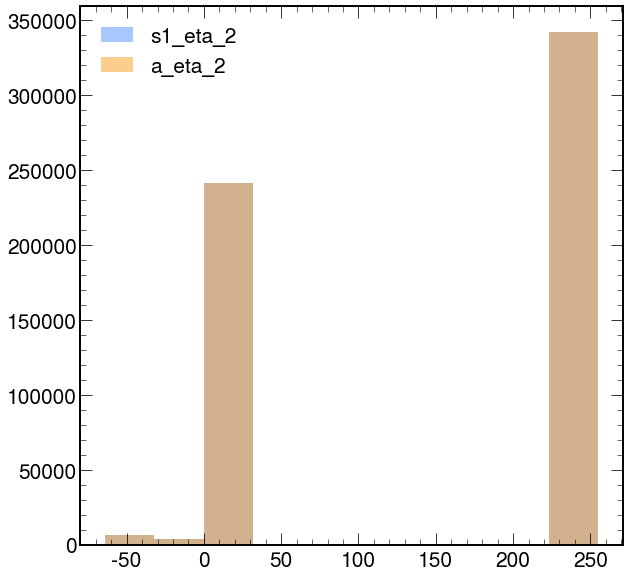

In [99]:
feature_to_check = 's1_eta_2'
feature_reb = 'a_eta_2'

full_2 = full_data[full_data['n_stubs'] == 2]
mask_9999 = full_2[feature_to_check] != -9999

plt.hist(full_2[feature_to_check][full_2[feature_to_check] != -9999], alpha=0.5, label=feature_to_check)
plt.hist(data_2[feature_reb][data_2['info_a'] == 1], alpha=0.5, label= feature_reb)
plt.legend()
plt.show()

In [107]:
#check element per element 
a = full_2[feature_to_check][full_2[feature_to_check] != -9999]
b = data_2[feature_reb][data_2['info_a'] == 1]
for i in range(len(full_2)):
    print(a.iloc[i] - b.iloc[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


IndexError: single positional indexer is out-of-bounds